In [2]:
import numpy as np
import cv2 
import re
import pandas as pd
import os

import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
from torchvision.models.resnet import resnet34
from torchvision.models.vgg import vgg11

from tqdm import tqdm_notebook as tqdm 
import matplotlib.pyplot as plt
%matplotlib inline

import sys
sys.path.append('..')

ROOT = '/home/user/data/twins_aligned_cropped_resized'

os.environ['CUDA_VISIBLE_DEVICES']='0'

In [3]:
from data.transforms import get_transform_base, get_transform_kp, std, mean
from albumentations import Compose, Normalize, CenterCrop, Resize
from albumentations.torch import ToTensor

# define crop transform of your choice
crop = 512
# resize = 320

# center crop + normalize
transform = Compose([CenterCrop(crop, crop),
#                      Resize(resize, resize),
                     Normalize(mean, std)], 
                   to_tensor=ToTensor(),)
#                    keypoint_params={'format': 'xy', 'remove_invisible': False})

In [4]:
# front images for each id
views = pd.read_csv(os.path.join(ROOT, 'df', 'views.csv'), index_col=0)
views.index = views.index.astype(str)
views.filename = views.filename.apply(eval)

# pairs including 50% of same identities
pairs_train = pd.read_csv(os.path.join(ROOT, 'df', 'pairs_train.csv'), index_col=0)
pairs_val = pd.read_csv(os.path.join(ROOT, 'df', 'pairs_test.csv'), index_col=0)

In [23]:
views_val.to_csv(os.path.join(ROOT, 'df', 'views_val.csv'), index=False)
views_train.to_csv(os.path.join(ROOT, 'df', 'views_train.csv'), index=False)

In [5]:
pairs_val.head()

,id_1,id_2,label
4,90144,90144,Same
12,90412,90412,Same
15,90245,90245,Same
17,90341,90341,Same
25,90314,90314,Same


In [10]:
ids_val = pairs_val.id_1.unique()
ids_train = pairs_train.id_1.unique()

ids_val = [str(x) for x in ids_val]
ids_train = [str(x) for x in ids_train]

In [12]:
len(ids_val), len(ids_train), len(np.intersect1d(ids_train, ids_val))

(134, 359, 58)

In [14]:
intersection = np.intersect1d(ids_train, ids_val)
ids_val_clean = [id_val for id_val in ids_val if id_val not in intersection]

In [15]:
len(ids_val_clean)

76

In [6]:
pairs_train.head()

,id_1,id_2,label
0,90308,90308,Same
1,90404,90404,Same
2,90062,90062,Same
3,90052,90052,Same
5,90317,90317,Same


In [8]:
views.head()

,filename,subject_id,label
person_id,,,
90003,"[90003d17.jpg, 90003d18.jpg, 90003d40.jpg, 900...",90003,0
90004,"[90004d17.jpg, 90004d18.jpg, 90004d40.jpg, 900...",90004,1
90005,"[90005d17.jpg, 90005d18.jpg, 90005d40.jpg, 900...",90005,2
90006,"[90006d14.jpg, 90006d15.jpg, 90006d37.jpg, 900...",90006,3
90007,"[90007d17.jpg, 90007d18.jpg, 90007d36.jpg, 900...",90007,4


In [19]:
views_val = views.loc[ids_val_clean]
views_val.head()

,filename,subject_id,label
person_id,,,
90144,"[90144d22.jpg, 90144d23.jpg, 90144d61.jpg, 901...",90144,139
90412,"[90412d13.jpg, 90412d28.jpg]",90412,369
90245,"[90245d1.jpg, 90245d13.jpg, 90245d16.jpg, 9024...",90245,204
90341,"[90341d10.jpg, 90341d15.jpg]",90341,298
90314,"[90314d13.jpg, 90314d18.jpg]",90314,271


In [20]:
views_train = views.loc[ids_train]
views_train.head()

,filename,subject_id,label
person_id,,,
90308,"[90308d13.jpg, 90308d18.jpg]",90308,265
90404,"[90404d13.jpg, 90404d18.jpg]",90404,361
90062,"[90062d22.jpg, 90062d23.jpg, 90062d60.jpg, 900...",90062,59
90052,"[90052d17.jpg, 90052d18.jpg, 90052d56.jpg, 900...",90052,49
90317,"[90317d13.jpg, 90317d18.jpg]",90317,274


In [6]:
pairs_val[pairs_val.label=='Same'].shape, pairs_train.shape, pairs_val.shape

((76, 3), (646, 3), (208, 3))

### Data

In [7]:
from data.dataset import TwinPairsDataset
from sklearn.model_selection import train_test_split

In [8]:
# pairs_train, pairs_val = train_test_split(pairs, test_size=0.2, shuffle=True, random_state=42)

In [9]:
pairs_train.shape, pairs_val.shape

((646, 3), (208, 3))

In [10]:
batch_size = 10
keypoints = False
train_dataset = TwinPairsDataset(ROOT, pairs_train, views, transform=transform, keypoints=keypoints)
val_dataset = TwinPairsDataset(ROOT, pairs_val, views, transform=transform, keypoints=keypoints)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=False)

loaders = {'train': train_loader, 'val': val_loader}

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


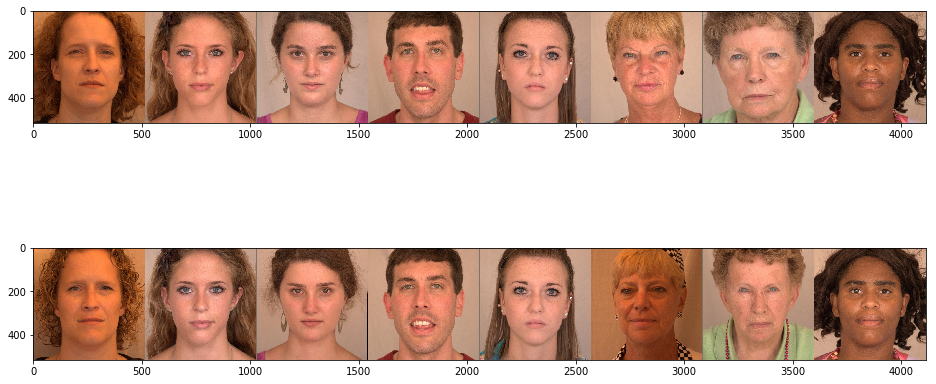

In [11]:
batch = next(iter(train_loader))
grid_1 = make_grid(batch['image1'][:8])
grid_2 = make_grid(batch['image0'][:8])

fig, axs = plt.subplots(2, 1, figsize=(16, 8))

axs[0].imshow(grid_1.numpy().transpose(1,2,0)*std + mean)
axs[1].imshow(grid_2.numpy().transpose(1,2,0)*std + mean)

### Model

In [12]:
from torch.optim import Adam
from torch.nn import functional as F
import copy

device = torch.device('cuda:0')

In [13]:
class SiameseModel(nn.Module):
    def __init__(self, cnn, num_cnn_features):
        super().__init__() 
        self.cnn = cnn
#         self.kp = nn.Linear(num_kp*2, num_kp)
#                                   nn.ReLU(True),
#                                   nn.Linear(num_cnn_features//2, 1))
        
        self.conv1 = nn.Conv2d(4, 32, kernel_size=(4,1), padding=2)
        self.conv2 = nn.Conv2d(32, 1, kernel_size=(32,1), padding=0)
        self.linear =  nn.Linear(2410, 1)
        
#         nn.Sequential(nn.Linear(num_cnn_features, num_cnn_features//2),
#                                   nn.ReLU(True),
#                                   nn.Linear(num_cnn_features//2, 1))
        
    def forward(self, sample):
        features_a = self.cnn(sample['image0'])
        features_b = self.cnn(sample['image1'])
        
#         kp_a = sample['keypoints0'].view(batch_size, -1).float()
#         kp_b = sample['keypoints1'].view(batch_size, -1).float()
        
#         kp = self.kp(torch.cat([kp_a, kp_b], 1))        
        
        f_abs = torch.abs(features_a-features_b)
        f_mult = features_a*features_b
        f_sum = features_a+features_b
        f_sq = f_abs**2
        
        x = torch.transpose(torch.stack([f_abs, f_mult, f_sum, f_sq]), 0, 1)[..., None]
#         print(x.shape)
        x = F.relu(self.conv1(x))
        x = self.conv2(x)
        x = x.view(x.size(0), -1)
#         print(x.shape)
        x = self.linear(x)
#         features = torch.cat([features, kp], dim=1)
#         print(features.shape)

#         out = self.head(features)
        return x
    
class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()
        
    def forward(self, x):
        return x

In [14]:
x = torch.zeros(16,512)

In [15]:
torch.transpose(torch.stack([x,x]), 0,1).shape

torch.Size([16, 2, 512])

In [16]:
base_model = resnet34(pretrained=True)

In [17]:
# base_model.avgpool = nn.AdaptiveAvgPool2d(1)
# num_cnn_features = 32768# base_model.fc.in_features
# base_model.classifier = Identity()

In [18]:
base_model.avgpool = nn.AdaptiveAvgPool2d(1)
num_cnn_features = base_model.fc.in_features
base_model.fc = Identity()

In [19]:
base_model(batch['image0']).shape

torch.Size([10, 512])

In [20]:
model = SiameseModel(base_model, num_cnn_features).to(device)

In [21]:
for key in batch:
    batch[key] = batch[key].to(device)

In [22]:
model(batch)

tensor([[-0.0157],
        [-0.0084],
        [-0.0015],
        [-0.0096],
        [-0.0282],
        [-0.0340],
        [ 0.0064],
        [-0.0095],
        [ 0.0067],
        [-0.0045]], device='cuda:0', grad_fn=<ThAddmmBackward>)

In [23]:
def train_model(model, criterion, optimizer, num_epochs=25, scheduler=None, writer=None):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = []
            running_corrects = []
            tq = tqdm(total=len(loaders[phase]))
            
            # Iterate over data.
            for sample in loaders[phase]:
                for key in sample:
                    sample[key] = sample[key].to(device)
                sample['label'] = sample['label'] .float()

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(sample)
                    preds = (outputs.sigmoid()>0.5).float()# (outputs>0).float()
                    loss = criterion(outputs, sample['label'][:,None]) 

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss.append(loss.item())
                running_corrects.append(torch.mean((preds == sample['label'].data).float()).detach().cpu().numpy())
                
                tq.update()
                running_acc = np.mean(running_corrects)
                tq.set_postfix(acc=f'{running_acc:.3f}')
            tq.close()
            epoch_loss = np.mean(running_loss)
            
            if phase == 'val':
                if scheduler:
                    scheduler.step(epoch_loss)
            epoch_acc = np.mean(running_corrects)
            
            if writer:
                writer.add_scalar(f'{phase}_loss', epoch_loss, epoch)
                writer.add_scalar(f'{phase}_accuracy', epoch_acc, epoch)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

#     time_elapsed = time.time() - since
#     print('Training complete in {:.0f}m {:.0f}s'.format(
#         time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
#     writer.close()
    return model

In [26]:
criterion = nn.BCEWithLogitsLoss()
optimizer = Adam(model.parameters(), lr=1e-5)

In [27]:
train_model(model, criterion, optimizer)

Process Process-49:
Process Process-52:
Process Process-51:
Process Process-50:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/opt/conda/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 96, in _worker_loop
    r = index_queue.get(timeout=MANAGER_STATUS_CHECK_INTERVAL)
Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 96, in _worker_loop
    r = index_queue.get(timeout=MANAGER_STATUS_CHECK_INTE

KeyboardInterrupt: 

  File "/opt/conda/lib/python3.6/multiprocessing/connection.py", line 911, in wait
    ready = selector.select(timeout)
  File "/opt/conda/lib/python3.6/multiprocessing/connection.py", line 257, in poll
    return self._poll(timeout)
  File "/opt/conda/lib/python3.6/selectors.py", line 376, in select
    fd_event_list = self._poll.poll(timeout)
  File "/opt/conda/lib/python3.6/multiprocessing/queues.py", line 104, in get
    if not self._poll(timeout):
  File "/opt/conda/lib/python3.6/selectors.py", line 376, in select
    fd_event_list = self._poll.poll(timeout)
  File "/opt/conda/lib/python3.6/multiprocessing/connection.py", line 414, in _poll
    r = wait([self], timeout)
  File "/opt/conda/lib/python3.6/multiprocessing/connection.py", line 257, in poll
    return self._poll(timeout)
KeyboardInterrupt
KeyboardInterrupt
  File "/opt/conda/lib/python3.6/multiprocessing/connection.py", line 911, in wait
    ready = selector.select(timeout)
  File "/opt/conda/lib/python3.6/multiprocessi